<a href="https://colab.research.google.com/github/CarloCV10/datasharing/blob/master/GDP_FNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data shapes: X_train: (125, 6), y_train: (125,)
Data shapes: X_test: (32, 6), y_test: (32,)
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 1.5740 - val_loss: 0.2415
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.4960 - val_loss: 0.2194
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.4251 - val_loss: 0.1984
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.3581 - val_loss: 0.1789
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.2949 - val_loss: 0.1609
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.2353 - val_loss: 0.1444
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.1788 - val_loss: 0.1293
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.1256 - val_loss: 0.1152
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.0756 - val_loss: 0.1024
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.0285 - val_loss: 0.0908
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.9839 - val_loss: 0.0805
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.9416 - val_loss: 0.0714
E

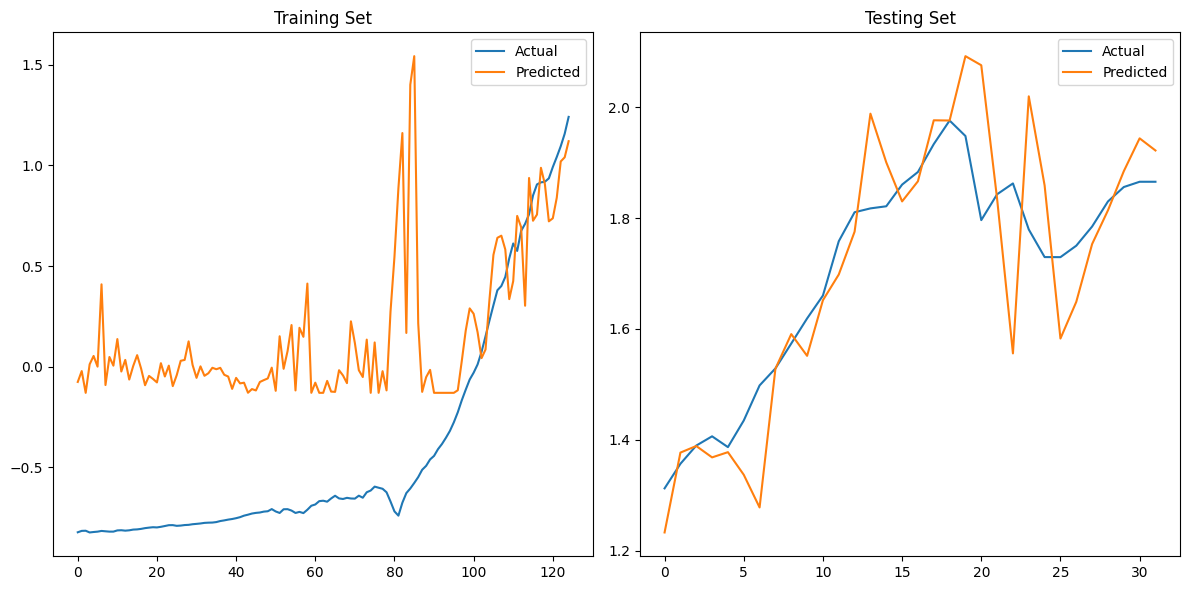

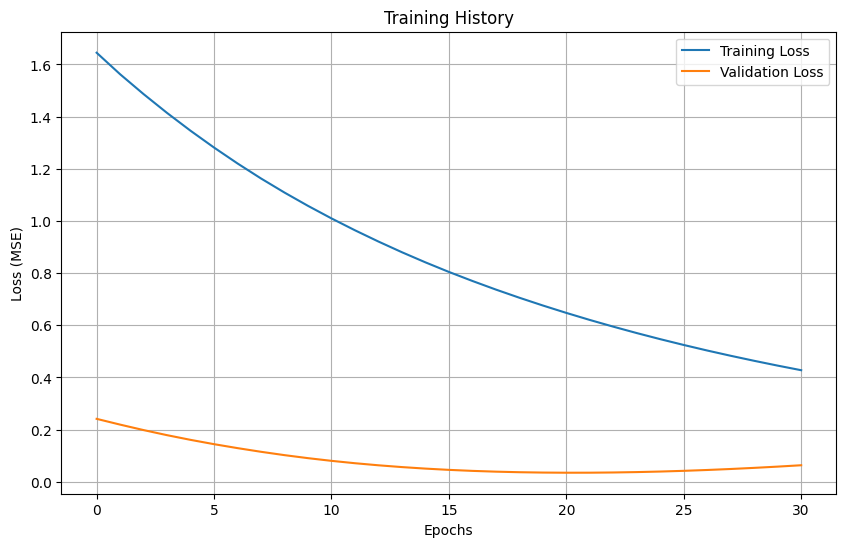

In [35]:
# FNN V0.1 : first model, pre optimization, only changed training loop to avoid subdle future bias. Performance remains solid.

# ----------------------------------------------------------------------------------
# 1. LIBRARIES AND PARAMETERS DEFINITION
# ----------------------------------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import math
import os
import random

# Parameters (easy to tweak)
SEED = 42
LAG_SIZE = 3
INPUT_WINDOW_SIZE = LAG_SIZE * 2  # 2 features (abs and delta GDP) per lagNUM_NEURONS = 18  # 3 neurons per input size
NUM_NEURONS = 3
NUM_LAYERS = 2
BATCH_SIZE = 24
NUM_EPOCHS = 100
ALPHA = 0.001  # Learning rate for optimizer
PATIENCE = 10
TRAIN_SPLIT = 0.8

# Set seeds for reproducibility
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# ----------------------------------------------------------------------------------
# 2. DATA LOADING AND PREPROCESSING
# ----------------------------------------------------------------------------------
def load_and_preprocess_data(file_path='italy_gdp_data_fnn.csv', lag_size=LAG_SIZE, train_split=TRAIN_SPLIT):
    """
    Load GDP data and prepare it for training/testing.
    Expects CSV with columns: year, abs_gdp, delta_gdp

    Parameters:
    - lag_size: Number of lagged values per feature (3 means t-1, t-2, t-3)
    """
    # Load data
    df = pd.read_csv(file_path)

    # Create sequences
    X, y = [], []

    # For each valid sequence position
    for i in range(lag_size, len(df)):
        # Get lag_size past values for both abs and delta GDP
        features = []

        # Add lagged values for abs_gdp
        for lag in range(1, lag_size + 1):
            features.append(df.iloc[i-lag, 1])  # abs_gdp column

        # Add lagged values for delta_gdp
        for lag in range(1, lag_size + 1):
            features.append(df.iloc[i-lag, 2])  # delta_gdp column

        # Target is the next absolute GDP
        target = df.iloc[i, 1]  # abs_gdp column

        X.append(features)
        y.append(target)

    X = np.array(X)
    y = np.array(y)

    # Split into train and test sets (time-ordered)
    split_idx = int(len(X) * train_split)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    return X_train, X_test, y_train, y_test

# ----------------------------------------------------------------------------------
# 3. NETWORK BUILDING
# ----------------------------------------------------------------------------------
def build_model(input_size=INPUT_WINDOW_SIZE, num_neurons=NUM_NEURONS, num_layers=NUM_LAYERS, alpha=ALPHA):
    """
    Build the FNN model with specified architecture
    """
    model = Sequential()

    # Input layer
    model.add(Dense(num_neurons, activation='relu', input_shape=(input_size,)))

    # Hidden layers
    for _ in range(num_layers - 1):
        model.add(Dense(num_neurons, activation='relu'))

    # Output layer (single value prediction)
    model.add(Dense(1))

    # Compile model
    optimizer = tf.keras.optimizers.Adam(learning_rate=alpha)
    model.compile(optimizer=optimizer, loss='mse')

    return model

# ----------------------------------------------------------------------------------
# 4. LEARNING FUNCTION
# ----------------------------------------------------------------------------------
def create_callbacks(patience=PATIENCE):
    """
    Create callbacks for model training
    """
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True,
        verbose=1
    )

    return [early_stopping]

# ----------------------------------------------------------------------------------
# 5. TRAINING LOOP
# ----------------------------------------------------------------------------------
def train_model(X_train, y_train, X_test, y_test, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, patience=PATIENCE):
    """
    Train the model and return history and trained model
    """
    # Create a validation split from the training data
    # This preserves test data as truly unseen
    # AND maintains temporal ordering (earlier->training, later->validation)
    validation_split = 0.2  # Use 20% of training data for validation
    split_idx = int(len(X_train) * (1 - validation_split))

    X_train_split = X_train[:split_idx]  # Earlier data for training
    X_val = X_train[split_idx:]         # Later data for validation
    y_train_split = y_train[:split_idx]
    y_val = y_train[split_idx:]

    # Build model
    model = build_model()

    # Set up callbacks
    callbacks = create_callbacks(patience)

    # Train model
    history = model.fit(
    X_train_split, y_train_split,    # Use manually defined training data
    validation_data=(X_val, y_val),  # Use manually defined validation data
    shuffle=False,                   # ✅ Critical for time series
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1
    )

    return model, history

# ----------------------------------------------------------------------------------
# 6. OUTCOMES, METRICS, INTERPRETATION AND ASSESSMENT
# ----------------------------------------------------------------------------------
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Evaluate model performance using MAPE and RMSE%
    """
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate RMSE
    rmse_train = math.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = math.sqrt(mean_squared_error(y_test, y_test_pred))

    # Calculate RMSE as percentage
    rmse_pct_train = (rmse_train / np.mean(y_train)) * 100
    rmse_pct_test = (rmse_test / np.mean(y_test)) * 100

    # Calculate MAPE
    mape_train = np.mean(np.abs((y_train - y_train_pred.flatten()) / y_train)) * 100
    mape_test = np.mean(np.abs((y_test - y_test_pred.flatten()) / y_test)) * 100

    # Print metrics
    print("\n===== MODEL EVALUATION =====")
    print(f"Training RMSE: {rmse_train:.4f} ({rmse_pct_train:.2f}%)")
    print(f"Testing RMSE: {rmse_test:.4f} ({rmse_pct_test:.2f}%)")
    print(f"Training MAPE: {mape_train:.2f}%")
    print(f"Testing MAPE: {mape_test:.2f}%")

    # Visualize predictions vs actuals
    plt.figure(figsize=(12, 6))

    # Training data
    plt.subplot(1, 2, 1)
    plt.plot(y_train, label='Actual')
    plt.plot(y_train_pred, label='Predicted')
    plt.title('Training Set')
    plt.legend()

    # Testing data
    plt.subplot(1, 2, 2)
    plt.plot(y_test, label='Actual')
    plt.plot(y_test_pred, label='Predicted')
    plt.title('Testing Set')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Return metrics for further analysis
    return {
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'rmse_pct_train': rmse_pct_train,
        'rmse_pct_test': rmse_pct_test,
        'mape_train': mape_train,
        'mape_test': mape_test
    }

# ----------------------------------------------------------------------------------
# MAIN EXECUTION
# ----------------------------------------------------------------------------------
def main():
    # Load and preprocess data
    X_train, X_test, y_train, y_test = load_and_preprocess_data()

    print(f"Data shapes: X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"Data shapes: X_test: {X_test.shape}, y_test: {y_test.shape}")

    # Train model
    model, history = train_model(X_train, y_train, X_test, y_test)

    # Evaluate model
    metrics = evaluate_model(model, X_train, y_train, X_test, y_test)

    # Plot training history
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training History')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model, metrics

# Run if executed as script
if __name__ == "__main__":
    model, metrics = main()

In [6]:
# ----------------------------------------------------------------------------------
# 5. TRAINING LOOP ORIGINAL, test validation leakage (V0.0)
# ----------------------------------------------------------------------------------
def train_model(X_train, y_train, X_test, y_test, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, patience=PATIENCE):
    """
    Train the model and return history and trained model
    """
    # Build model
    model = build_model()

    # Set up callbacks
    callbacks = create_callbacks(patience)

    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )

    return model, history

Ok first model was surprisingly good from the beginning. We rapidly excluded overfitting (training metrics were significantly worse than test, suggesting a genuine learning curve) and even when controlling for future bias (learning curve looks solid and not aggressive, data uploading and processing logics is good, found a small subtelty in the training loop which could have caused future bias, removed it) performance did not move and remained better than ARiMA optimized version:
         
          ===== MODEL EVALUATION =====
          Training RMSE: 0.7148 (-171.21%)
          Testing RMSE: 0.1153 (6.75%)
          Training MAPE: 114.43%
          Testing MAPE: 4.65%

Particular efficiency in forecasting during volatile period, even tho the general trend had been caugh by the 1975/80. Also, sensitivity to crisis periods was very high, despite the direction and magnitude effects of the crisis were off my significant margins. Still, the FNN suggests great baility to detect abnormalities and ring bells, as suggested by the WWII moment. First outcomes were already superior to the utmost optimized ARiMA model, which had to give up on rigorous stationarity assumptions (d=1).

Ok as for optimization, we have first tried increasing complexity:
V1.1
# Parameters
SEED = 42
LAG_SIZE = 4
INPUT_WINDOW_SIZE = LAG_SIZE * 2  
NUM_NEURONS = 5
NUM_LAYERS = 4
BATCH_SIZE = 24
NUM_EPOCHS = 150
ALPHA = 0.001  # Learning rate for optimizer
PATIENCE = 15
TRAIN_SPLIT = 0.8

Most likely, the dataset is too scarce for this level of complexity (only 159 * 2 total data points) which mostly introduces random noise before allowing for learning.

          ===== MODEL EVALUATION =====
          Training RMSE: 0.7759 (-187.34%)
          Testing RMSE: 1.5875 (92.93%)
          Training MAPE: 111.66%
          Testing MAPE: 92.77%

However, the model still remained highly sensitive to the war through, suggesting that shocks and crisis volatility is still highly detectable by FNN.
Even after further tweaking (accomodating learning parameters for higher complexity), data scarcity remained a fundamental issues, no signs of improvement were detected in the direction of complexity. Ultimately, complexity was an optimizing horizon to be forgotten.

We move to V2 of optimization, optimizing learning.
Upon trying iterative changes of learning rate, batch size, epoch, patience and lag size, no substantial progess was achieved. Mostly higher errors, only reached comparative levels of performance (within +-.1% of the firs iteration metrics). This suggest that for the current architecture, dataset and level of complexity, optimal performance didn't need optimization neither benefitted from it.

Residual testing (visual, distribution, Ljung-Box test) suggesting no overfitting, Temporal dependencies are well-managed, genuine predictive strength — not just memorizing noise.


Data shapes: X_train: (125, 6), y_train: (125,)
Data shapes: X_test: (32, 6), y_test: (32,)
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 1.5635 - val_loss: 0.2352
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.4575 - val_loss: 0.2078
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.3631 - val_loss: 0.1827
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.2762 - val_loss: 0.1599
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.1959 - val_loss: 0.1396
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.1218 - val_loss: 0.1212
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0538 - val_loss: 0.1046
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9910 - val_loss: 0.0901
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.9325 - val_loss: 0.0775
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.8780 - val_loss: 0.0669
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.8275 - val_loss: 0.0580
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.7806 - val_loss: 0.0508
E

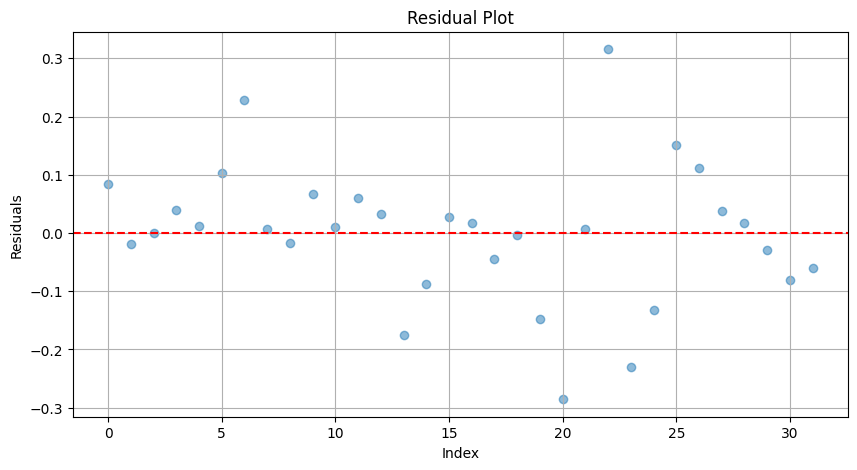

     lb_stat  lb_pvalue
10  15.72615   0.107745


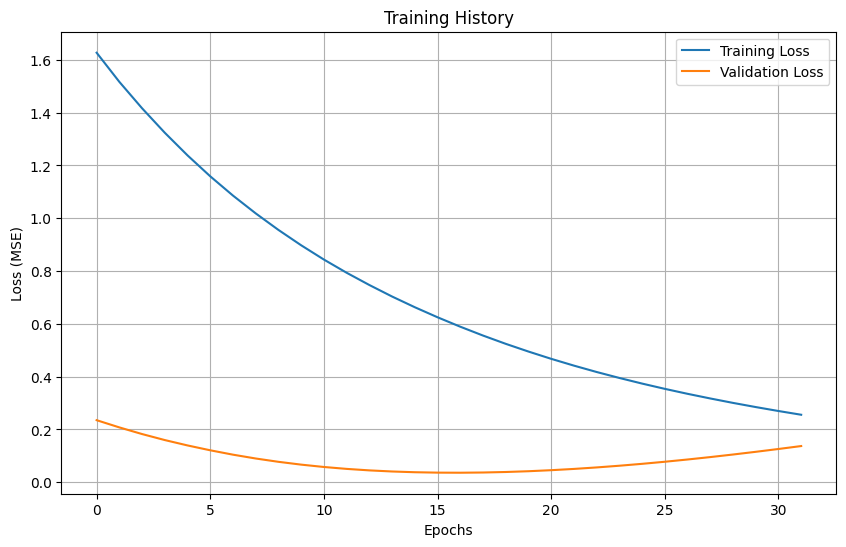

In [40]:
# Residual Testing
# ----------------------------------------------------------------------------------
# 1. LIBRARIES AND PARAMETERS DEFINITION
# ----------------------------------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import math
import os
import random

# Parameters (easy to tweak)
SEED = 42
LAG_SIZE = 3
INPUT_WINDOW_SIZE = LAG_SIZE * 2
NUM_NEURONS = 3
NUM_LAYERS = 2
BATCH_SIZE = 16
NUM_EPOCHS = 100
ALPHA = 0.001  # Learning rate for optimizer
PATIENCE = 15
TRAIN_SPLIT = 0.8

# Set seeds for reproducibility
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# ----------------------------------------------------------------------------------
# 2. DATA LOADING AND PREPROCESSING
# ----------------------------------------------------------------------------------
def load_and_preprocess_data(file_path='italy_gdp_data_fnn.csv', lag_size=LAG_SIZE, train_split=TRAIN_SPLIT):
    """
    Load GDP data and prepare it for training/testing.
    Expects CSV with columns: year, abs_gdp, delta_gdp

    Parameters:
    - lag_size: Number of lagged values per feature (3 means t-1, t-2, t-3)
    """
    # Load data
    df = pd.read_csv(file_path)

    # Create sequences
    X, y = [], []

    # For each valid sequence position
    for i in range(lag_size, len(df)):
        # Get lag_size past values for both abs and delta GDP
        features = []

        # Add lagged values for abs_gdp
        for lag in range(1, lag_size + 1):
            features.append(df.iloc[i-lag, 1])  # abs_gdp column

        # Add lagged values for delta_gdp
        for lag in range(1, lag_size + 1):
            features.append(df.iloc[i-lag, 2])  # delta_gdp column

        # Target is the next absolute GDP
        target = df.iloc[i, 1]  # abs_gdp column

        X.append(features)
        y.append(target)

    X = np.array(X)
    y = np.array(y)

    # Split into train and test sets (time-ordered)
    split_idx = int(len(X) * train_split)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    return X_train, X_test, y_train, y_test

# ----------------------------------------------------------------------------------
# 3. NETWORK BUILDING
# ----------------------------------------------------------------------------------
def build_model(input_size=INPUT_WINDOW_SIZE, num_neurons=NUM_NEURONS, num_layers=NUM_LAYERS, alpha=ALPHA):
    """
    Build the FNN model with specified architecture
    """
    model = Sequential()

    # Input layer
    model.add(Dense(num_neurons, activation='relu', input_shape=(input_size,)))

    # Hidden layers
    for _ in range(num_layers - 1):
        model.add(Dense(num_neurons, activation='relu'))

    # Output layer (single value prediction)
    model.add(Dense(1))

    # Compile model
    optimizer = tf.keras.optimizers.Adam(learning_rate=alpha)
    model.compile(optimizer=optimizer, loss='mse')

    return model

# ----------------------------------------------------------------------------------
# 4. LEARNING FUNCTION
# ----------------------------------------------------------------------------------
def create_callbacks(patience=PATIENCE):
    """
    Create callbacks for model training
    """
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True,
        verbose=1
    )

    return [early_stopping]

# ----------------------------------------------------------------------------------
# 5. TRAINING LOOP
# ----------------------------------------------------------------------------------
def train_model(X_train, y_train, X_test, y_test, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, patience=PATIENCE):
    """
    Train the model and return history and trained model
    """
    # Create a validation split from the training data
    # This preserves test data as truly unseen
    # AND maintains temporal ordering (earlier->training, later->validation)
    validation_split = 0.2  # Use 20% of training data for validation
    split_idx = int(len(X_train) * (1 - validation_split))

    X_train_split = X_train[:split_idx]  # Manual splits Earlier data for training
    X_val = X_train[split_idx:]
    y_train_split = y_train[:split_idx]
    y_val = y_train[split_idx:]

    # Build model
    model = build_model()

    # Set up callbacks
    callbacks = create_callbacks(patience)

    # Train model
    history = model.fit(
    X_train_split, y_train_split,
    validation_data=(X_val, y_val),
    shuffle=False,                   # No shuffling for time series
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1
    )

    return model, history

# ----------------------------------------------------------------------------------
# 6. OUTCOMES, METRICS, INTERPRETATION AND ASSESSMENT
# ----------------------------------------------------------------------------------
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Evaluate model performance using MAPE and RMSE%, and compute residuals.
    """
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # 🔥 Residuals Definition (Add this here)
    train_residuals = y_train - y_train_pred.flatten()
    test_residuals = y_test - y_test_pred.flatten()

    # Metrics Calculation
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    rmse_pct_train = (rmse_train / np.mean(y_train)) * 100
    rmse_pct_test = (rmse_test / np.mean(y_test)) * 100
    mape_train = np.mean(np.abs((y_train - y_train_pred.flatten()) / y_train)) * 100
    mape_test = np.mean(np.abs((y_test - y_test_pred.flatten()) / y_test)) * 100

    # Display Results
    print("\n===== MODEL EVALUATION =====")
    print(f"Training RMSE: {rmse_train:.4f} ({rmse_pct_train:.2f}%)")
    print(f"Testing RMSE: {rmse_test:.4f} ({rmse_pct_test:.2f}%)")
    print(f"Training MAPE: {mape_train:.2f}%")
    print(f"Testing MAPE: {mape_test:.2f}%")

    # Visualizing Residuals
    plt.figure(figsize=(10, 5))
    plt.scatter(range(len(test_residuals)), test_residuals, alpha=0.5)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title("Residual Plot")
    plt.xlabel("Index")
    plt.ylabel("Residuals")
    plt.grid(True)
    plt.show()

    from statsmodels.stats.diagnostic import acorr_ljungbox

    ljung_box_result = acorr_ljungbox(test_residuals, lags=[10], return_df=True)
    print(ljung_box_result)

    # Return Metrics and Residuals
    return {
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'rmse_pct_train': rmse_pct_train,
        'rmse_pct_test': rmse_pct_test,
        'mape_train': mape_train,
        'mape_test': mape_test,
        'train_residuals': train_residuals,    # ✅ Residuals now available for further tests
        'test_residuals': test_residuals       # ✅ Residuals now available for further tests
    }

# ----------------------------------------------------------------------------------
# MAIN EXECUTION
# ----------------------------------------------------------------------------------
def main():
    # Load and preprocess data
    X_train, X_test, y_train, y_test = load_and_preprocess_data()

    print(f"Data shapes: X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"Data shapes: X_test: {X_test.shape}, y_test: {y_test.shape}")

    # Train model
    model, history = train_model(X_train, y_train, X_test, y_test)

    # Evaluate model
    metrics = evaluate_model(model, X_train, y_train, X_test, y_test)

    # Plot training history
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training History')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model, metrics

# Run if executed as script
if __name__ == "__main__":
    model, metrics = main()

In [38]:
from statsmodels.stats.diagnostic import acorr_ljungbox

ljung_box_result = acorr_ljungbox(test_residuals, lags=[10], return_df=True)
print(ljung_box_result)

NameError: name 'test_residuals' is not defined